# Study distribution of Radio Power of QSOs

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import getpass
import progressbar
import pandas as pd
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux_radio(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [6]:
def lum_from_flux(flux, redshift):  # Flux in mJy, general version, without K-correction
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26  # in W/Hz
    return luminosity

In [7]:
def flux_from_lum_radio(lum, redshift):  # Lum in W/Hz
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    flux         = lum * 1e3 * 1e26 / (4 * np.pi * lum_distance**2) / (1 + redshift)**(alpha_used - 1)  # in mJy
    return flux

In [8]:
def limit_redshift(lums, redshifts, min_flxs):  # Calculates max redshift at which object might be detected
    final_z  = []
    values_idx = np.arange(np.shape(redshifts)[0])
    with progressbar.ProgressBar(min_value=0, max_value=np.shape(redshifts)[0]) as bar:
        for lum, redshift, min_flx, value_idx in zip(lums, redshifts, min_flxs, values_idx):
            temp_z   = redshift
            temp_flx = flux_from_lum_radio(lum, redshift)
            for z in np.arange(temp_z, 10, 0.01):
                temp_flx = flux_from_lum_radio(lum, z)
                int_z = z
                if temp_flx <= min_flx:
                    break
            final_z.append(int_z)
            bar.update(value_idx)
    return np.array(final_z)   

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [9]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [10]:
cmap            = cm.get_cmap('inferno')
dark_color      = cmap(0.4)  # RGBA color code
light_color     = cmap(0.6)  # RGBA color code
colors          = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8        = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [11]:
cmap_alt        = cm.get_cmap('summer')
dark_color_alt  = cmap_alt(0.4)  # RGBA color code
light_color_alt = cmap_alt(0.6)  # RGBA color code
colors_alt      = [cmap_alt(0.15), cmap_alt(0.30), cmap_alt(0.45), cmap_alt(0.60), cmap_alt(0.75), cmap_alt(0.90)]
colors_8_alt    = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.60), cmap_alt(0.72),\
                   cmap_alt(0.84), cmap_alt(0.96)]

In [12]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Function to create scatter plot of quotients of features vs redshift.

In [13]:
def plot_scatter_quotient(quot, col_a, col_b, ax1, filter_finite):
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    scatter_out  = ax1.scatter(redshift_df[filter_finite].values[indices], quot[filter_finite].values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o',\
                               s=85, cmap='Dark2', edgecolor='k', linewidths=0.5)
    
    col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
    col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'
    
    axis_label   = f'${col_a_label} / {col_b_label}$'
    
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    ax1.set_xlabel('redshift', size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_label, size=14)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11})
    plt.setp(ax1.spines.values(), linewidth=2.5)

Function to create scatter plots of features showing their origin (survey)  
and not the redshift values.

In [14]:
def plot_scatter_origin(col_a, col_b, ax1, filter_finite, use_rescaled=False):
    if not use_rescaled:
        array_a       = lums_catalog_df[col_a][filter_finite]
        array_b       = lums_catalog_df[col_b][filter_finite]
    if use_rescaled:
        array_a       = norm_lums_catalog_df[col_a][filter_finite]
        array_b       = norm_lums_catalog_df[col_b][filter_finite]
    
    min_val       = np.nanmin([array_a.min(), array_b.min()])
    max_val       = np.nanmax([array_a.max(), array_b.max()])
    
    # Add 1-1 line and parallels for comparison
    ax1.plot([min_val*0.7, max_val*1.3], [min_val*0.7, max_val*1.3], ls='dashed', color='k', alpha=0.45, lw=1)
    for factor in [1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16]:  # [1e3, 1e6, 1e9, 1e12]
        ax1.plot([min_val*0.7, max_val], [min_val*factor*0.7, max_val*factor], ls='dashed', color='k', alpha=0.45, lw=1)
        ax1.plot([min_val*0.7, max_val*factor], [min_val/factor*0.7, max_val], ls='dashed', color='k', alpha=0.45, lw=1)
    
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    scatter_out  = ax1.scatter(array_a.values[indices], array_b.values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o', s=85, cmap='Dark2',\
                               edgecolor='k', linewidths=0.5)
    
    col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
    col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'
    
    if not use_rescaled:
        axis_a_label   = f'${col_a_label}  \, [W/Hz]$'
        axis_b_label   = f'${col_b_label}  \, [W/Hz]$'
    if use_rescaled:
        axis_a_label   = f'${col_a_label}  \, [Normalized Units]$'
        axis_b_label   = f'${col_b_label}  \, [Normalized Units]$'
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    # ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    ax1.set_xlabel(axis_a_label, size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11}, loc=0)
    plt.setp(ax1.spines.values(), linewidth=2.5)

Function to create scatter plots with histograms for features.

In [15]:
def plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, z_limit, plot_hst_flg=True, use_rescaled=True, high_z=False):
    # Obtain luminosities and the cross-match between them
    if not use_rescaled:
        lum_a         = lums_catalog_df[col_a]
        lum_b         = lums_catalog_df[col_b]
    if use_rescaled:
        lum_a         = norm_lums_catalog_df[col_a]
        lum_b         = norm_lums_catalog_df[col_b]
    common_vals   = np.multiply(lum_a, lum_b)
    filter_finite = np.isfinite(common_vals) & np.array(common_vals > 0) & np.array(redshift_df > z_limit)
    
    # Create log bins for log-scale histograms
    min_val       = np.nanmin([lum_a[filter_finite].min(), lum_b[filter_finite].min()])
    max_val       = np.nanmax([lum_a[filter_finite].max(), lum_b[filter_finite].max()])
    bins_a        = np.logspace(np.log10(lum_a[filter_finite].values.min()), np.log10(lum_a[filter_finite].values.max()), 30)
    bins_b        = np.logspace(np.log10(lum_b[filter_finite].values.min()), np.log10(lum_b[filter_finite].values.max()), 30)
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label   = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{W/Hz}]'
        col_b_label   = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{W/Hz}]'
    if use_rescaled:
        col_a_label   = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label   = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label  = f'${col_a_label}$'
    axis_b_label  = f'${col_b_label}$'
        
    ax1.set_xlabel(axis_a_label, size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    
    # Add 1-1 line and parallels for comparison
    ax1.plot([min_val*0.7, max_val*1.3], [min_val*0.7, max_val*1.3], ls='dashed', color='k', alpha=0.45, lw=1)
    for factor in [1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16]:  # [1e3, 1e6, 1e9, 1e12]
        ax1.plot([min_val*0.7, max_val], [min_val*factor*0.7, max_val*factor], ls='dashed', color='k', alpha=0.45, lw=1)
        ax1.plot([min_val*0.7, max_val*factor], [min_val/factor*0.7, max_val], ls='dashed', color='k', alpha=0.45, lw=1)
    
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    sc_plot        = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
                                 c=redshift_df[filter_finite].values[indices], cmap='inferno_r',\
                                 s=(origin_df[filter_finite].values[indices] + 1.5)**4, alpha=0.80, edgecolor='k')  # s=30
    
    # Create colorbar and plot it
    cbaxes         = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
    clb            = plt.colorbar(sc_plot, cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=12) 
    # clb.set_label('redshift', size=14)
    clb.ax.set_title('redshift', size=14)
    
    # produce a legend with the unique colors from the scatter
    classes        = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 1.5)**4]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    ax1.legend(handles=sc_plot.legend_elements(prop='sizes')[0], labels=classes, loc=0, prop={'size': 14},  edgecolor='k')
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    ax1.set_aspect('auto', share=False, adjustable='box')
    
    if plot_hst_flg:
        # Plot vertical histogram
        hist(lum_b[filter_finite].values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('N', size=14)
        
        # Plot horizontal histogram
        hist(lum_a[filter_finite].values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_ylabel('N', size=14)
        
        # Modify ticks
        ax2.tick_params(axis='both', which='major', labelsize=14)
        ax3.tick_params(axis='both', which='major', labelsize=14)
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.setp(ax3.get_xticklabels(), visible=False)
        plt.setp(ax2.spines.values(), linewidth=2.5)
        plt.setp(ax3.spines.values(), linewidth=2.5)
        ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
        ax3.tick_params(which='both',top=True, right=True, direction='in')
        ax2.tick_params(which='major', length=8, width=1.5)
        ax2.tick_params(which='minor', length=4, width=1.5)
        ax3.tick_params(which='major', length=8, width=1.5)
        ax3.tick_params(which='minor', length=4, width=1.5)
        
        plt.subplots_adjust(wspace=0.0, hspace=0.0)

---

## Reading data

In [16]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

We separate our data in luminosities and redshift values (column name `z_value`).

It is important to keep in mind that columns with luminosity values start their names with `Luminosity...`  
and they are in `W / Hz`.  

Uncertainties have not been included up to this point. They are included (as flux uncertainties in the file `large_cat_simbad_inayoshi_ned.h5`).

In [17]:
# file_name        = 'large_cat_lums_z_clean_ago2020.h5'
file_name        = 'large_cat_flux_errs_clean_ago2020.h5'

In [18]:
large_catalog_full_df = pd.read_hdf(cat_path + file_name, 'df')

In [19]:
flux_catalog_df      = large_catalog_full_df.drop(columns=['z_val', 'origin', 'RA', 'DEC', 'name_init',\
                                                            'name_new', 'refs', 'z_val_err', 'flx_lim'])

In [20]:
redshift_df           = large_catalog_full_df['z_val']
redshift_e_df         = large_catalog_full_df['z_val_err']
origin_df             = large_catalog_full_df['origin']  # 0:SDSS+FIRST, 1:COSMOS, 2:Stripe82, 3:Inayoshi
coord_ra_deg          = large_catalog_full_df['RA']
coord_dec_deg         = large_catalog_full_df['DEC']
orig_names            = large_catalog_full_df['name_init']
newer_names           = large_catalog_full_df['name_new']
flx_limits_df         = large_catalog_full_df['flx_lim']  # mJy

In [21]:
coords_arr            = pd.Series(SkyCoord(coord_ra_deg, coord_dec_deg, unit=u.degree), index=coord_ra_deg.index)

Data could be also converted into `astropy` Tables.

In [22]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [23]:
# np.savetxt(cat_path + 'column_names_lums.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

Missing values have been replaced with the number $-99.0$ which, in the context of our dataset,  
is a very unlikely quantity to be found.

If needed (not for the moment) these values can be masked and treated as proper missing values.

In [24]:
filter_limit_flx = np.array(flx_limits_df ==  1)

In [25]:
flux_catalog_df[flux_catalog_df == -99.0] = None
flux_catalog_df[flux_catalog_df <=  00.0] = None
flx_limits_df[filter_limit_flx]           = None

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We, now, can convert these fluxes into luminosities.  
In this case, we have not applied K-correction factors of any kind.  
Thus, these luminosities are useful for comparison purposes only.

In [26]:
lums_catalog_df = flux_catalog_df.apply(lum_from_flux, args=[redshift_df])

In [27]:
lums_catalog_df[lums_catalog_df == -99.0] = None
lums_catalog_df[lums_catalog_df <=  00.0] = None

In [28]:
lums_catalog_df.columns = lums_catalog_df.columns.str.replace('Flux', 'Luminosity')

Since we will explore, mostly, graphically our data, it is possible  
to rescale our dataset to values between $0$ and $1$.

In [29]:
min_max_scaler        = preprocessing.MaxAbsScaler()
x_scaled              = min_max_scaler.fit_transform(lums_catalog_df.values)
norm_lums_catalog_df  = pd.DataFrame(data=x_scaled,\
                                columns=lums_catalog_df.columns) 

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:978: RuntimeWarning: All-NaN slice encountered
  max_abs = np.nanmax(np.abs(X), axis=0)


---

In [30]:
all_flx_cols  = flux_catalog_df.columns
all_lum_cols  = lums_catalog_df.columns

In [31]:
filt_cols_err = np.array(['Flux Error' in column for column in all_flx_cols])
filt_cols_upl = np.array(['Upper Limit' in column for column in all_flx_cols])
filt_cols_flx = ~(filt_cols_err | filt_cols_upl)

In [32]:
cols_flx      = all_flx_cols[filt_cols_flx]
cols_err_flx  = all_flx_cols[filt_cols_err]
cols_upl_flx  = all_flx_cols[filt_cols_upl]

In [33]:
cols_lum      = all_lum_cols[filt_cols_flx]
cols_err_lum  = all_lum_cols[filt_cols_err]
cols_upl_lum  = all_lum_cols[filt_cols_upl]

Define frequencies of previous bands for calculating luminosities.

In [34]:
# bands_freqs = {}
# freq_values = np.sort([1.36e14, 1.82e14, 2.40e14, 3.50e14, 3.90e14, 4.70e14, 5.42e14, 6.17e14, 6.90e14,\
#                        8.36e14, 1.30e15, 1.95e15, 1.00e07, 7.00e07, 1.50e08, 3.00e08, 6.00e08, 1.40e09,\
#                        3.00e09, 1.00e10, 3.00e10, 7.00e10, 1.00e11, 3.00e11, 8.57e11, 3.00e12, 1.20e13,\
#                        7.00e13, 9.00e17, 1.00e25])  # Hz
# for band_name, freq in zip(large_catalog_df.columns, freq_values):
#     bands_freqs[band_name] = freq

In [35]:
bands_freqs = {}
freq_values = np.sort([1.00e07, 7.00e07, 1.50e08, 3.00e08, 6.0e008, 1.00e09, 1.40e09, 3.00e09, 1.00e10, 3.00e10, 7.00e10,\
                       1.00e11, 1.40e11, 3.00e11, 8.57e11, 3.00e12, 1.20e13, 7.00e13, 1.36e14, 1.82e14, 2.40e14, 3.50e14,\
                       3.90e14, 4.70e14, 5.42e14, 6.17e14, 6.90e14, 8.36e14, 1.30e15, 1.95e15, 2.47e15, 9.00e17, 2.53e19,\
                       1.21e25])  # Hz
for band_name, freq in zip(cols_flx, freq_values):
    bands_freqs[band_name] = freq

---

In [36]:
# limit_z_a = 3.0
# limit_z_b = 4.0
# filter_z  = np.array((redshift_df > limit_z_a) & (redshift_df < limit_z_b))

In [37]:
vmin_l = np.nanmin(lums_catalog_df['Luminosity 1.4-1.7 GHz'])
vmax_l = np.nanmax(lums_catalog_df['Luminosity 1.4-1.7 GHz'])
bins_l = np.logspace(np.log10(vmin_l), np.log10(vmax_l), 30)

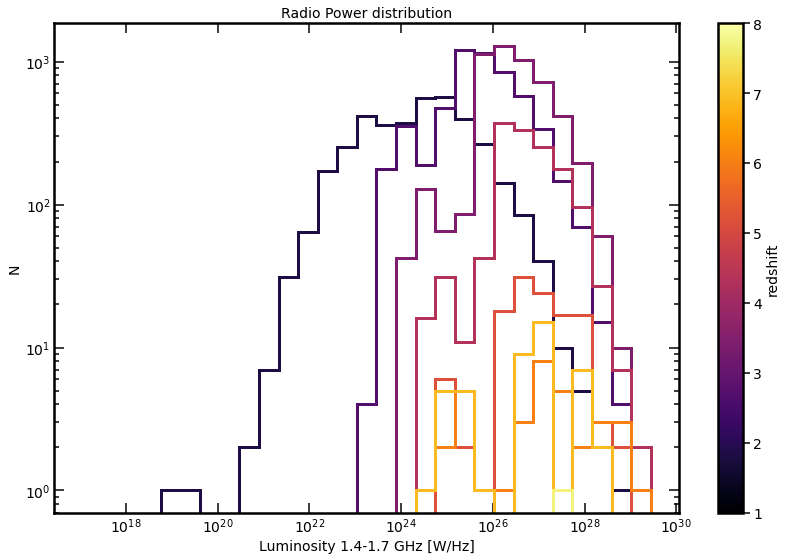

In [38]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)

for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z  = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z  = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z  = np.array(redshift_df < lim_val)  # lower redshift than value
    vals = hist(lums_catalog_df.loc[filter_z, 'Luminosity 1.4-1.7 GHz'], bins=bins_l,\
                        histtype='step', color=colors_8[lim_val - 1], ax=ax1, cumulative=False, lw=3.0, density=False)
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=8))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N', size=14)
ax1.set_xlabel('Luminosity 1.4-1.7 GHz [W/Hz]', size=14)
ax1.set_title('Radio Power distribution', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

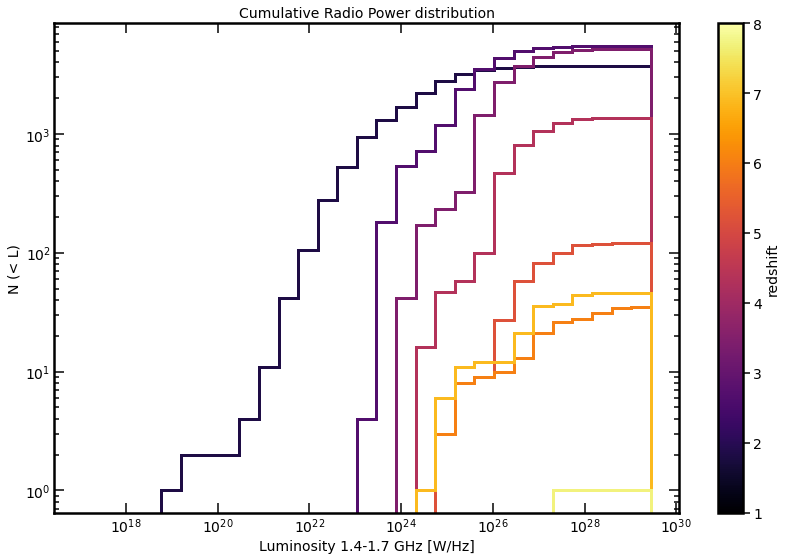

In [39]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)

for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z  = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z  = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z  = np.array(redshift_df < lim_val)  # lower redshift than value
    vals = hist(lums_catalog_df.loc[filter_z, 'Luminosity 1.4-1.7 GHz'], bins=bins_l,\
                        histtype='step', color=colors_8[lim_val - 1], ax=ax1, cumulative=True, lw=3.0, density=False)
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=8))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N (< L)', size=14)
ax1.set_xlabel('Luminosity 1.4-1.7 GHz [W/Hz]', size=14)
ax1.set_title('Cumulative Radio Power distribution', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

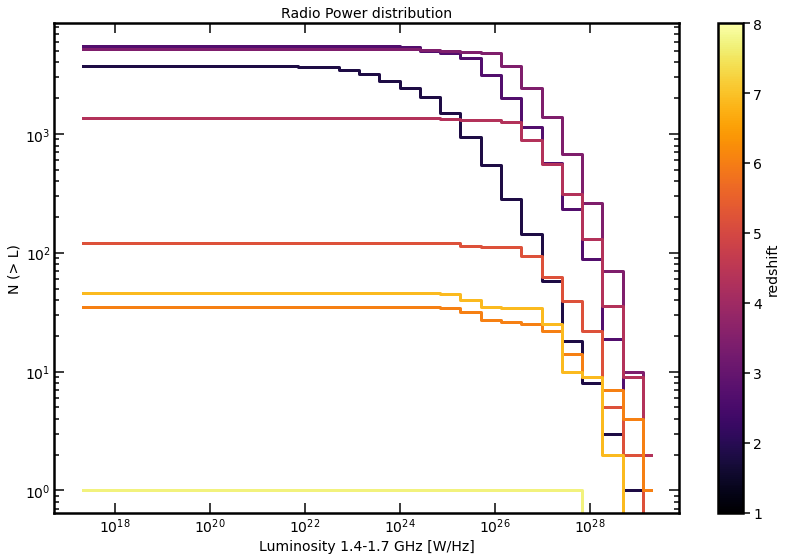

In [40]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)


for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z     = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z     = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z     = np.array(redshift_df < lim_val)  # lower redshift than value
    vals, bins_e = np.histogram(lums_catalog_df.loc[filter_z, 'Luminosity 1.4-1.7 GHz'], bins=bins_l, density=False)
    width_e      = np.diff(bins_e)
    center_e     = (bins_e[:-1] + bins_e[1:]) / 2
    for counter, frac in enumerate(vals):
        num_high      = np.sum(vals[counter:])
        vals[counter] = num_high
    ax1.step(center_e, vals, where='mid', c=colors_8[lim_val -1], lw=3.0)
    
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=8))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N (> L)', size=14)
ax1.set_xlabel('Luminosity 1.4-1.7 GHz [W/Hz]', size=14)
ax1.set_title('Radio Power distribution', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

---

# Calculate $V_{max}$ to correct for Malmquist bias.

We need to take into account limiting flux/magnitudes for the different  
catalogs we use in this work.

Careful calculation must be taken with sources from **Inayoshi et al., 2020**, since  
they have been obtained from several surveys and pointed observations with  
very different configurations.

**FIRST**: $1$ mJy limit ($0.15$ $\mu$Jy rms)  
**COSMOS**: $45$ $\mu$Jy limit ($10.5$ $\mu$Jy rms)  
**Stripe82**: $52$ $\mu$Jy

In [41]:
z_lims = limit_redshift(lums_catalog_df['Luminosity 1.4-1.7 GHz'], redshift_df, flx_limits_df)

100% (19840 of 19840) |##################| Elapsed Time: 0:24:53 Time:  0:24:53


In [42]:
lums_catalog_df['Limiting redshift'] = z_lims

In [43]:
lums_catalog_df['Limiting distance'] = cosmo.luminosity_distance(lums_catalog_df['Limiting redshift']).value  # Mpc

In [44]:
lums_catalog_df['Max volume']        = 4 * np.pi * lums_catalog_df['Limiting distance']**3 / 3

In [45]:
lums_catalog_df['Present volume']    = 4 * np.pi * (cosmo.luminosity_distance(redshift_df).value)**3 / 3  # Mpc

In [46]:
lums_catalog_df['Volume ratio']      = lums_catalog_df['Present volume'] / lums_catalog_df['Max volume']

In [47]:
lums_catalog_df['Max volume'].describe()

count    1.984000e+04
mean     3.038155e+15
std      2.046830e+15
min      4.492126e+05
25%      4.440645e+14
50%      4.674513e+15
75%      4.681473e+15
max      4.690478e+15
Name: Max volume, dtype: float64

In [48]:
vmin_vol = np.nanmin(lums_catalog_df['Volume ratio'])
vmax_vol = np.nanmax(lums_catalog_df['Volume ratio'])
bins_vol = np.logspace(np.log10(vmin_vol), np.log10(vmax_vol), 30)

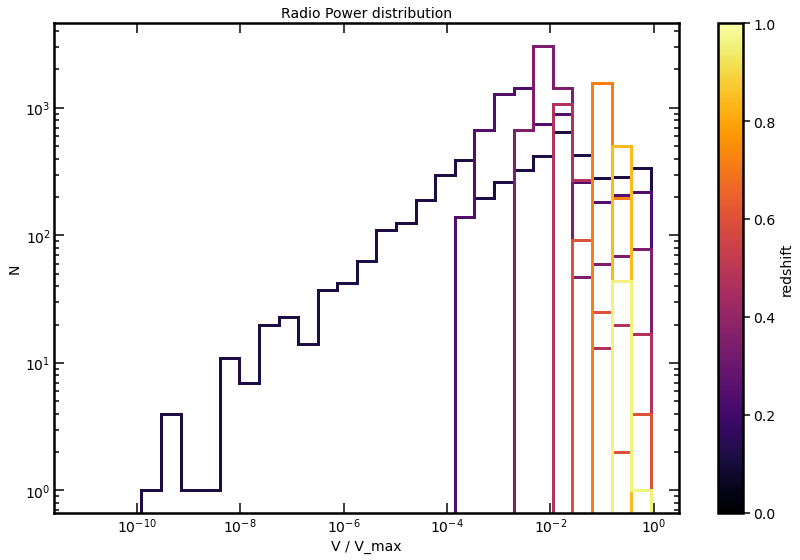

In [49]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)

for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z  = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z  = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z  = np.array(redshift_df < lim_val)  # lower redshift than value
    vals = hist(lums_catalog_df.loc[filter_z, 'Volume ratio'], bins=bins_vol, histtype='step',\
                color=colors_8[lim_val - 1], ax=ax1, cumulative=False, lw=3.0, density=False)
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N', size=14)
ax1.set_xlabel('V / V_max', size=14)
ax1.set_title('Radio Power distribution', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

In [50]:
weights_vol = 1 / lums_catalog_df['Max volume']

In [51]:
sum_weights = np.nansum(weights_vol)

In [52]:
sum_weights

3.5069097774690996e-06

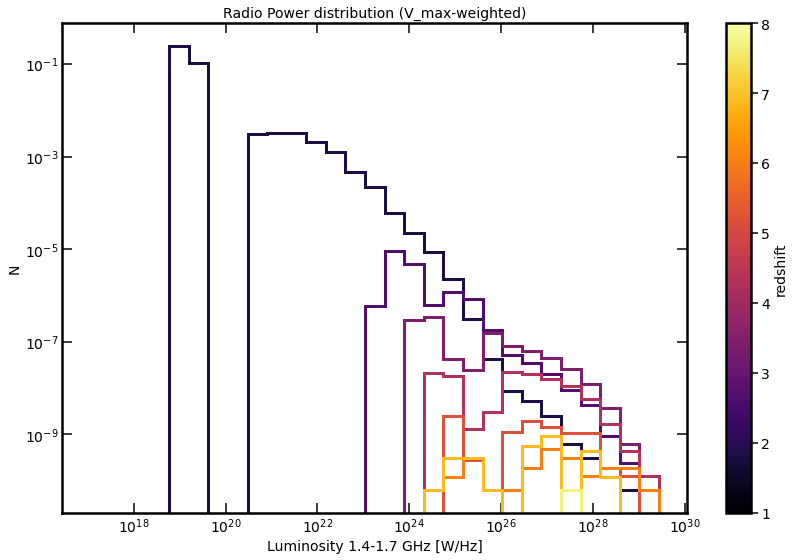

In [53]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)

for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z  = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z  = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z  = np.array(redshift_df < lim_val)  # lower redshift than value
    vals = hist(lums_catalog_df.loc[filter_z, 'Luminosity 1.4-1.7 GHz'], bins=bins_l,\
                histtype='step', color=colors_8[lim_val - 1], ax=ax1, cumulative=False, lw=3.0,\
                density=False, weights=(weights_vol.loc[filter_z] / sum_weights))
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=8))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N', size=14)
ax1.set_xlabel('Luminosity 1.4-1.7 GHz [W/Hz]', size=14)
ax1.set_title('Radio Power distribution (V_max-weighted)', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

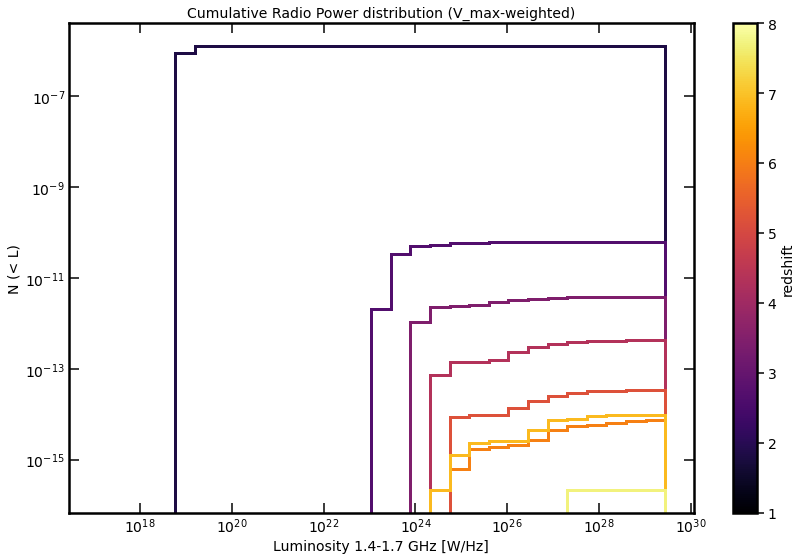

In [54]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)

for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z  = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z  = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z  = np.array(redshift_df < lim_val)  # lower redshift than value
    vals = hist(lums_catalog_df.loc[filter_z, 'Luminosity 1.4-1.7 GHz'], bins=bins_l,\
                histtype='step', color=colors_8[lim_val - 1], ax=ax1, cumulative=True, lw=3.0,\
                density=False, weights=weights_vol.loc[filter_z])
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=8))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N (< L)', size=14)
ax1.set_xlabel('Luminosity 1.4-1.7 GHz [W/Hz]', size=14)
ax1.set_title('Cumulative Radio Power distribution (V_max-weighted)', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

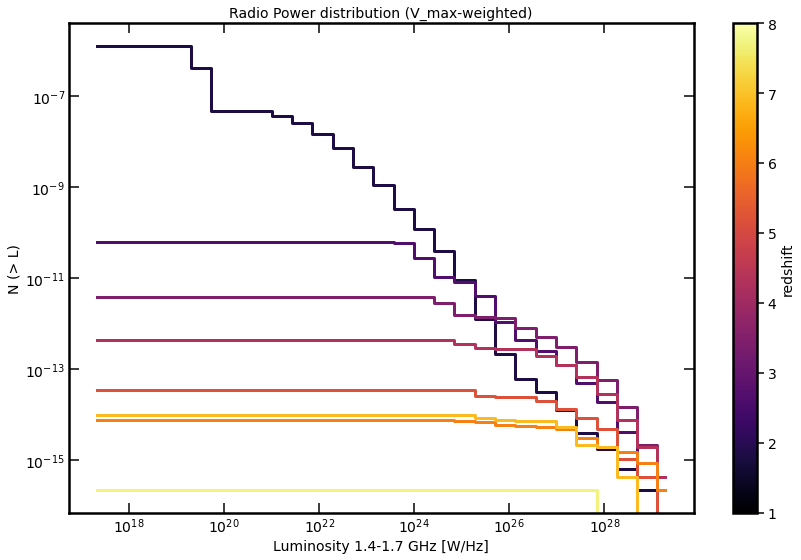

In [55]:
fig             = plt.figure(figsize=(14,9))
ax1             = fig.add_subplot(111)


for lim_val in [1, 2, 3, 4, 5, 6, 7, 8]:
    filter_z     = np.array((redshift_df > (lim_val - 1)) & (redshift_df < lim_val))  # In redshift range
    # filter_z     = np.array(redshift_df > (lim_val - 1))  # higher redshift than value
    # filter_z     = np.array(redshift_df < lim_val)  # lower redshift than value
    vals, bins_e = np.histogram(lums_catalog_df.loc[filter_z, 'Luminosity 1.4-1.7 GHz'], bins=bins_l,\
                                density=False, weights=weights_vol.loc[filter_z])
    width_e      = np.diff(bins_e)
    center_e     = (bins_e[:-1] + bins_e[1:]) / 2
    for counter, frac in enumerate(vals):
        num_high      = np.sum(vals[counter:])
        vals[counter] = num_high
    ax1.step(center_e, vals, where='mid', c=colors_8[lim_val -1], lw=3.0)
    
    

sm  = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=8))
clb = plt.colorbar(sm)

clb.ax.tick_params(labelsize=12)
clb.ax.set_ylabel('redshift', size=14)
clb.outline.set_linewidth(2.5)
clb.ax.tick_params(which='major', length=7, width=1.5)
clb.ax.tick_params(axis='both', which='major', labelsize=14)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('N (> L)', size=14)
ax1.set_xlabel('Luminosity 1.4-1.7 GHz [W/Hz]', size=14)
ax1.set_title('Radio Power distribution (V_max-weighted)', size=14)

ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=10, width=1.5)
ax1.tick_params(which='minor', length=5, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

ax1.set_aspect('auto', share=False, adjustable='box');

In [56]:
orig_label_mod = {(0 + 1.5)**4:'FIRST', (1 + 1.5)**4:'COSMOS+VLA', (2 + 1.5)**4:'Stripe82', (3 + 1.5)**4:'Inayoshi (z>5.5)'}

In [57]:
lum_names           = lums_catalog_df.columns

In [58]:
add_histograms_flag = True  # Add histograms to the folowing plot

In [59]:
z_limit        = 0.0  # Plot sources with redshift higher than this value

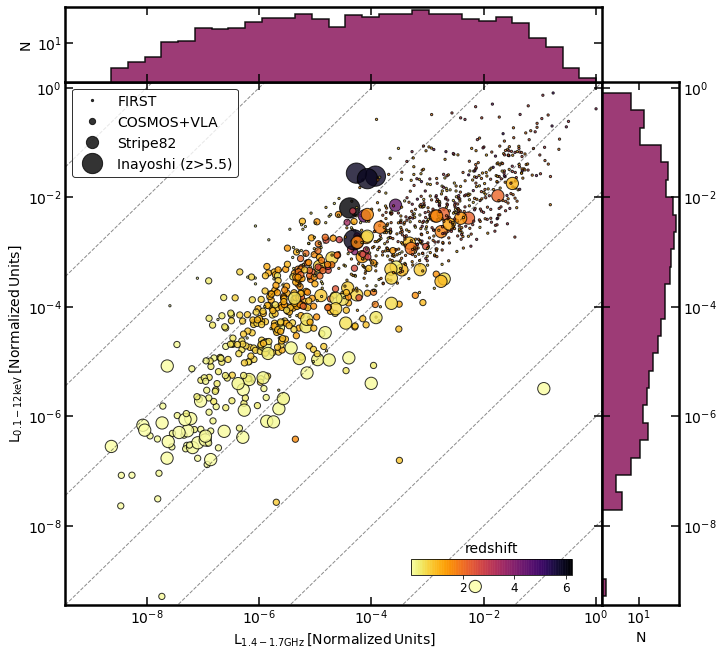

In [60]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity 1.4-1.7 GHz"
col_b         = "Luminosity 0.1-12 keV"

plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, z_limit, add_histograms_flag)

---